# Milestone 3: Random Forest Algorithm

**Authors**: __Khizer Zakir & Rodrigo Brust Santos__

__November 2023__

_____

In [34]:
#basic libraries
import pandas as pd
import numpy as np

#graphic and charts
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

#spatial libraries
import geopandas as gpd
import folium

# Table of Contents

1. Feedback

1. Hyperparameter Setting


2. Model Calibration


3.  Variable Selection


4. Model Evaluation


_____

In [2]:
#loading data frame
df = pd.read_csv('../dataset/stream_samples_basin_id.csv')

#removing columns that wont be used
df.drop(columns = ['geometry', 'index_right'], inplace = True)

df.rename(columns = {'OBJECTID':'basin_id'}, inplace = True)

df.head(2)

,x,y,Ag (ppm),Al (%),As (ppm),Ba (ppm),Be (ppm),Bi (ppm),Ca (%),Cd (ppm),...,Sr (ppm),Th (ppm),Ti (%),U (ppm),V (ppm),W (ppm),Y (ppm),Zn (ppm),Zr (ppm),basin_id
0,248757,7972050,0.03,2.63,4.0,76.0,1.0,0.31,0.05,0.03,...,3.3,7.4,0.03,0.70,73,0.3,13.15,27,6.3,2
1,244460,7973135,0.02,1.93,2.0,84.0,1.7,0.29,0.04,0.01,...,3.1,8.2,0.06,0.94,58,0.3,23.90,58,6.9,3


In [3]:
#variable that we will predict
Y_column = 'Zn (ppm)'

#explanatory variables
X_columns = list(df.iloc[:, :-1])

#dropping Zn from our explanatory variables
X_columns.remove('Zn (ppm)')

In [4]:
#generating the X and Y dataset and transforming to numpy array
X, Y = df[X_columns].to_numpy(), df[Y_column].to_numpy()

#defining the watershed number as the group
groups = df['basin_id'].to_numpy()


#### How we did

In [5]:
# test_size = 0.3 #setting the test size. 
n_splits = 4   #setting the number of splits, arbitrarly.

group_kfold = GroupKFold(n_splits=n_splits)

basin_kfold = group_kfold.split(X, Y, groups)

# Create a nested list of train and test indices for each fold
train_indices, test_indices = [list(traintest) for traintest in zip(*basin_kfold)]

basin_cv = [*zip(train_indices,test_indices)]

In [6]:
# model
linear_clf = LinearRegression().fit(X, Y)

# fit and predict at the same time consdering the cv = basin_cv takes care of the data splitting

y_pred = cross_val_predict(linear_clf, X, Y, cv=basin_cv, groups=groups)

r2 = r2_score(Y, y_pred)

print('R2: ',round(r2,2))

R2:  0.57


### Another approach

In [7]:
# Create a GroupKFold object with the desired number of splits (k)
k = 4
group_kfold_two = GroupKFold(n_splits=k)

# Specify the fold you want to use (fold_index should be less than k)
fold_index = [1,2,3]

r2_scores, mse_scores, rmse_scores = [], [], []

for i in fold_index:

    # Get indices for the specified fold
    train_index, test_index = list(group_kfold_two.split(X, Y, groups))[i - 1]

    #print('Train-Test Shapes', train_index.shape, test_index.shape)

    # Use the indices to get the training and testing sets
    X_train, X_test = X[train_index], X[test_index]

    #print('X Train-Test Shapes', X_train.shape, X_test.shape)
    
    y_train, y_test = Y[train_index], Y[test_index]
    #print('Y Train-Test Shapes', y_train.shape, y_test.shape)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred_two = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred_two)
    rmse = mean_squared_error(y_test, y_pred_two, squared=False)
    mse = mean_squared_error(y_test, y_pred_two)

    print(f'R2 - Index: {i} ',round(r2,2))
    print(f'RMSE:', round(rmse,2))
    print(f'MSE:', round(mse,2))

    r2_scores.append(r2)
    mse_scores.append(mse)
    rmse_scores.append(rmse)

R2 - Index: 1  0.53
RMSE: 15.31
MSE: 234.27
R2 - Index: 2  0.62
RMSE: 14.14
MSE: 199.84
R2 - Index: 3  0.55
RMSE: 11.66
MSE: 135.84


In [8]:
round(np.mean(r2_scores),2), round(np.mean(rmse_scores),2), round(np.mean(mse_scores),2)

(0.56, 13.7, 189.99)

In [10]:
#using the optimal learning rate
r_rmse, r_mse, r_r2 = [], [], []
for i in fold_index:

    # Get indices for the specified fold
    train_index, test_index = list(group_kfold_two.split(X, Y, groups))[i - 1]

    #print('Train-Test Shapes', train_index.shape, test_index.shape)

    # Use the indices to get the training and testing sets
    X_train, X_test = X[train_index], X[test_index]

    #print('X Train-Test Shapes', X_train.shape, X_test.shape)
    
    y_train, y_test = Y[train_index], Y[test_index]
    #print('Y Train-Test Shapes', y_train.shape, y_test.shape)

    elastmodel = Ridge(alpha=4.83)
    
    elastmodel.fit(X_train, y_train)

    y_pred_ridge = elastmodel.predict(X_test)
        
    # Calculate evaluation metrics
    rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    r_rmse.append(rmse_ridge)
    r_mse.append(mse_ridge)
    r_r2.append(r2_ridge)

    print(f'Index {i}', r2_ridge, rmse_ridge, mse_ridge )

Index 1 0.5959173014095739 14.19358526782089 201.45786275490218
Index 2 0.6461940686823625 13.5744030918268 184.26441929939702
Index 3 0.5278142409741016 11.880613713672371 141.14898221350003


In [11]:
round(np.mean(r_r2),2), round(np.mean(r_rmse),2), round(np.mean(r_mse),2)

(0.59, 13.22, 175.62)

### 1. Hyperparameter Setting

• Recall what are the two most important hyperparameters. Propose a protocol that relies on the out-of-bag
(OOB) error to tune this hyperparameter.

The two most important hyperparameters for the random forest algorithm are:

- `max_features`: helps controlling the bias and variance for the forest. In case of having a small number of features, the trees are less correlated. By default, in regression problems, max_features starts with `d/3`, until being properly tuned.

- `n_estimators`: represents the amount of forests within the random forest. It's recommended starting with a high value in order to obtain a robust estimate.


First, the model will be implemented without any type of hyperparameter setting. Then, the main hyperparameters will be calculated, leading to the application to the model. Finaly, it will be visible the difference between the random forest tuned and the other that is not. 


In [25]:
#maxfeatures
d = round(df.shape[0]/3)

Below, we are setting the `RandomForestRegressor` within the variable `tree_clf`. 

The `n_estimators` was set as 500 arbitrarly. The ideia is that if there is a high value it's possible to get a stable estimate, and then change it to the tuned value.

`max_features` was set as the division of the length of the dataset by 3. Also to be tuned.

It was opted to have out-of-bag replacement to have an estimation of the generalization score.

Finally, the `random_state` was set to 42 in order to get the reproducibility.

In [26]:
tree_clf = RandomForestRegressor(n_estimators= 500, max_features=d, oob_score=True, random_state=42)

In [30]:
i = 1
train_index, test_index = list(group_kfold_two.split(X, Y, groups))[i - 1]

#print('Train-Test Shapes', train_index.shape, test_index.shape)

# Use the indices to get the training and testing sets
X_train, X_test = X[train_index], X[test_index]

#print('X Train-Test Shapes', X_train.shape, X_test.shape)

y_train, y_test = Y[train_index], Y[test_index]

In [31]:
#fitting data
tree_clf.fit(X_train, y_train)

RandomForestRegressor(max_features=236, n_estimators=500, oob_score=True,
                      random_state=42)

In [32]:
tree_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 236,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [33]:
oob_score = round(tree_clf.oob_score_,2)

print('OOB score: ', oob_score )

oob_error = 1 - oob_score
print('OOB error:', oob_error )

OOB score:  0.64
OOB error: 0.36


###  ^ INTERPRET THIS OOB SCORE, CHECK IF ITS RIGHT

In [47]:
pred_test = tree_clf.predict(X_test)

# Calculate evaluation metrics
rmse_tree_clf = mean_squared_error(y_test, pred_test, squared=False)

mse_tree_clf = mean_squared_error(y_test, pred_test)

r2_tree_clf = r2_score(y_test, pred_test)

print('Random Forest Regressor Scores without hyperparameter tunning')
print('#############################################################')
print('R2 Score:', round(r2_tree_clf,2))
print('MSE:', round(mse_tree_clf,2))
print('RMSE:', round(rmse_tree_clf,2))
print('#############################################################')

Random Forest Regressor Scores without hyperparameter tunning
#############################################################
R2 Score: 0.61
MSE: 194.78
RMSE: 13.96
#############################################################


### 2. Model Calibration

• For the calibrated model, measure the importance of each variable. Justify the choice of the importance
measure (why did you use this importance measure instead of another one?). Comment on the results:
according to the importance measure you chose, what are the most discriminant variables of your dataset?
Interpret

Justifying the parameters below:

- `warm_start`: to allow the reutilization of previous run, leading to the addition of more estimators to the ensable. **Explain it better maybe?**

- `max_features='auto'`: once the **n_estimators** is tuned, the next one to be tuned is the max_features. For now, let's keep it in auto.

In [57]:
error_rate = []

min_estimators = 100
max_estimators = 5000
step = 50

for i in range(min_estimators, max_estimators+1, step):
    rf_reg = RandomForestRegressor(warm_start=True, n_estimators= i, max_features='auto', random_state=42, oob_score=True)

    rf_reg.fit(X, Y)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf_reg.oob_score_

    error_rate.append(oob_error)
  



C:\Users\rodri\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\rodri\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\rodri\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

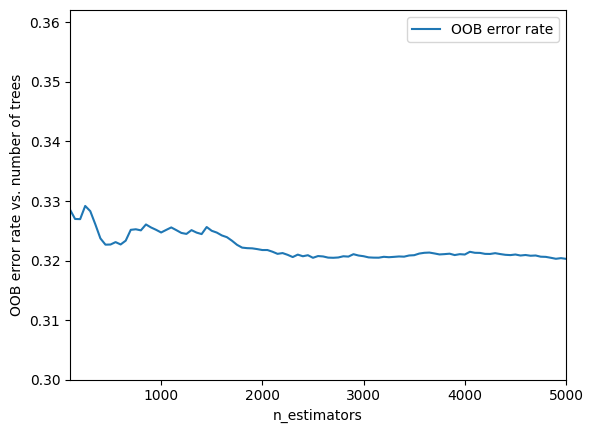

In [60]:
# Plot Generate the "OOB error rate" vs. "n_estimators" plot

plt.plot(range(min_estimators, max_estimators +1, step), error_rate, label="OOB error rate")

plt.ylim(0.3, 1.1*max(error_rate)) 
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate vs. number of trees")
plt.legend(loc="upper right")
plt.show()

Since the OOB error rate is almost flat around 3500 n_estimators, this is the value that will be used.

In [61]:
grid = {
    'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}

# Step 2: use the grid to to search for the best couple of parameters
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(n_estimators=3500) # create the forest model to tune

B=10
results_cv=pd.DataFrame()
for i in range(B):
    
    rf_cv = GridSearchCV(estimator=rf,param_grid=grid, cv=3,n_jobs=-1)# Search the best values for the parameters using 3-fold cross validation, and use all available cores(n_jobs=-1)
    rf_cv.fit(X, Y) # Fit the CV search
    if i==0: 
        results_cv=pd.DataFrame(rf_cv.cv_results_)[["params","mean_test_score","std_test_score"]]
    else:
        results_cv["mean_test_score"]=results_cv["mean_test_score"]+pd.DataFrame(rf_cv.cv_results_)["mean_test_score"]
        results_cv["std_test_score"]=results_cv["std_test_score"]+pd.DataFrame(rf_cv.cv_results_)["std_test_score"]  
        
        

results_cv["mean_test_score"]=results_cv["mean_test_score"]/B
results_cv["std_test_score"]=results_cv["std_test_score"]/B 


# Step 3: get the best parameters (with the higher performance)
print(results_cv)

                  params  mean_test_score  std_test_score
0  {'max_features': 0.1}         0.347916        0.190470
1  {'max_features': 0.2}         0.390107        0.154811
2  {'max_features': 0.3}         0.403438        0.140064
3  {'max_features': 0.4}         0.415536        0.124826
4  {'max_features': 0.5}         0.418034        0.118469
5  {'max_features': 0.6}         0.415669        0.115884
6  {'max_features': 0.7}         0.413358        0.115066
7  {'max_features': 0.8}         0.413011        0.114325
8  {'max_features': 0.9}         0.408646        0.115877


### 3.  Variable Selection

• Based on the feature importance analysis (previous question), conduct a selection of variables using one
of the strategies described during the lecture. Justify your choice and recall how the selected technique
works. Implement and run it. What is the final number of selected variables in the model? Justify if you
need to recalibrate the forest or not.


### 4. Model Evaluation

• Evaluate the test performance of the two random forest models (based on the full set of variables or
a subset) and determine the configuration of the best model (based on the main evaluation metric you
selected in step 1).